In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import concurrent.futures
import time
from numba import jit

In [2]:
start = time.time()

In [3]:
@jit(nopython=True)
def update_particle(history):

    r = np.full((history, 2), np.nan)

    def initialize_particles(r, history):
        for i in range(history):
            teta = np.random.uniform(0, 2*np.pi)
            position = np.random.uniform(0, radius)
            r[i, 0] = position * np.cos(teta)
            r[i, 1] = position * np.sin(teta)
    initialize_particles(r, history)

    fps = 20
    dt = 1/fps
    final_time = 200
    steps = int(final_time/dt)

    record = np.full((1, history, 2), np.nan)
    record[0,:,:] = r[:,:]
    init_record = record

    fuel = np.full((1, 2), np.nan)
    fr = 1

    def initialize_fuel(fuel):
        fuel[0, 0] = 0
        fuel[0, 1] = 0
    initialize_fuel(fuel)

    v = np.full((history, 2), np.nan)
    speed = 1

    def initialize_speed(v, history):
        for i in range(history):
            teta = np.random.uniform(0, 2*np.pi)
            v[i, 0] = speed * np.cos(teta)
            v[i, 1] = speed * np.sin(teta)
    initialize_speed(v, history)

    for i in range(1, steps):
        for j in range(history):
            if r[j, 0] == 11000:
                continue
            elif (fuel[0, 0] - fr <= r[j, 0] <= fuel[0, 0] + fr and
                  fuel[0, 1] - fr <= r[j, 1] <= fuel[0, 1] + fr and
                  np.sqrt(r[j, 0]**2 + r[j, 1]**2) <= fr):
                r[j,:] = 11000
                v[j,:] = 0
                r2 = np.full((2, 2), np.nan)
                initialize_particles(r2, 2)
                v2 = np.full((2, 2), np.nan)
                initialize_speed(v2, 2)
                r = np.concatenate((r, r2), axis=0)
                v = np.concatenate((v, v2), axis=0)
                history += 2
                record = np.full((steps, history, 2), np.nan)
                record[:, :history-2, :] = init_record
                init_record = record
                continue
            elif np.sqrt(r[j, 0]**2 + r[j, 1]**2) < radius:
                r[j, :] = r[j, :] + v[j, :] * dt
                continue
            else:
                distance_to_origin = np.sqrt(r[j, 0]**2 + r[j, 1]**2)
                normal_vector = np.array([r[j, 0], r[j, 1]]) / distance_to_origin
                dot_product = np.dot(np.array([v[j, 0], v[j, 1]]), normal_vector)
                v[j, 0] -= 2 * dot_product * normal_vector[0]
                v[j, 1] -= 2 * dot_product * normal_vector[1]
                r[j, :] = r[j, :] + v[j, :] * dt
        record[i,:,:] = r[:,:]
        init_record = record
    return record

In [4]:
radius = 5
fr = 1
fps = 20
speed = 1
if __name__ == '__main__':
    histories = [100, 100]
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = list(executor.map(update_particle, histories))

In [5]:
record = np.concatenate((results[0], results[1]), axis=1)
record.shape

(4000, 1116, 2)

In [6]:
end = time.time()
print(f'duration = {end-start}')

duration = 32.57174301147461


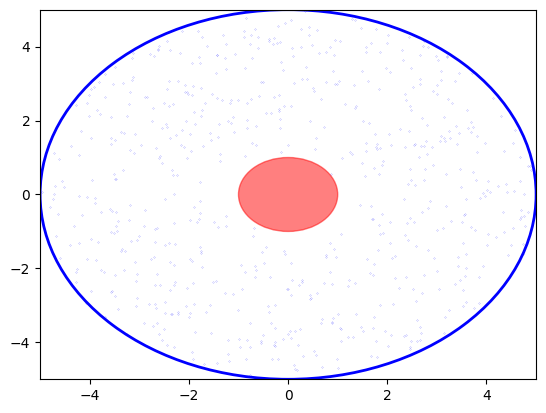

In [7]:
# Create a figure and axis for the animation
fig, ax = plt.subplots()
ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)

# Create a scatter plot for the particles with a specified size (e.g., ms=2)
particles, = ax.plot([], [], 'bo', ms=0.1)

# Create cylinder boundary
cylinder = plt.Circle((0, 0), radius, color='b', fill=False, lw=2)
ax.add_patch(cylinder)

# Create fuel region
fuel_region = plt.Circle((0, 0), fr, color='red', alpha=0.5)
ax.add_patch(fuel_region)

# Function to initialize the plot
def init():
    particles.set_data([], [])
    return particles,

# Function to update particle positions for each frame
def update(frame):
    x_data = record[frame,:,0].copy()
    y_data = record[frame,:,1].copy()
    particles.set_data(x_data, y_data)
    return particles,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(record), init_func=init, interval=50, blit=True)

# Set up the animation writer (for saving as a GIF)
Writer = animation.writers['pillow']
writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=1800)

# Save the animation as a GIF
ani.save('particle_animation.gif', writer=writer)

# Display the animation
plt.show()
